# Dale_Coeffs! :Tasselled Cap Wetness Brightness Greenness  for Kakadu

## Need to: change the normalization to a different stretch method when plotting RGB

### This notebook takes TCI coefficients developed by Dale and plots mean wetness, brightness and greenness as rgb. It then  plots greenness against wetness to get an idea of the shape of the tasselled cap.

__Inheritance__ <br>
Written by BexDunn on 131017 <br>
Based on the TCBG_Kakadu_131017 code as at 131017 <br>
Based on the raijin-code Dask_Wetness_debug1.py as at 140817. <br>

-------------------------------------------------------------------- 
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
---------------------------------------------------------------------

## Import the python modules we need

In [1]:
#for writing to error files:
from __future__ import print_function
#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
#from datacube.storage.masking import mask_to_dict #think this is obsolete
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys
import os.path

#####These not needed for raijin::::
import matplotlib.pyplot as plt
import matplotlib as mpl

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
from PIL import Image

def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)
        
    

## define functions to load nbart, calculate wetness, wetness over threshold, counts, and write datasets to netcdf

In [2]:
def load_nbart(sensor,query,bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [3]:
#calculating tasselled cap wetness
def calc_wetness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''
    
    wetness_coeff = {'ls5':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511},
                    'ls7':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511},
                    'ls8':{'blue':0.5702, 'green': 0.1584, 'red':0.2627, 'nir':-0.3959, 'swir1':-0.0045, 'swir2':-0.6511}}  
    #if there is sensor data for the time period
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None            

In [4]:
#calculating tasselled cap brightness
def calc_brightness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "brightness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''

    brightness_coeff = {'ls5':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214},
                    'ls7':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214},
                    'ls8':{'blue':0.3567, 'green':0.3567, 'red':0.3567, 'nir':0.535, 'swir1':0.535, 'swir2':0.214}}
#if there is sensor data for the time period
    if sensor_data is not None: 
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            brightness_band = sensor_data[band_name]*brightness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called bright_green etc.
            #then drop the original bands
            wbg.update({'bright_'+band_name:(['time','y','x'],brightness_band)})
            wbg = wbg.drop({band_name})    
        wbg['brightness']=wbg.bright_blue+wbg.bright_green+wbg.bright_red+wbg.bright_nir+wbg.bright_swir1+wbg.bright_swir2   
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('brightness')
        wbg = wbg.drop(bands_to_drop)
        print('calculated brightness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate brightness for {}'.format(sensor))
        return None        #calculating tasselled cap brightness

In [5]:
#calculating tasselled cap greenness
def calc_greenness(sensor_data,sensor):
    '''This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "brightness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Roberts 2018 in press
    function written 23-08-2017 based on dc v1.5.1. updated 06-11-2017 bd'''

    greenness_coeff = {'ls5':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68},
                       'ls7':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68},
                       'ls8':{'blue':-0.1987, 'green':-0.2826, 'red':-0.2724, 'nir':0.5357, 'swir1':0.2388, 'swir2':-0.68}}  
   #if there is sensor data for the time period
    if sensor_data is not None: 
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            greenness_band = sensor_data[band_name]*greenness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called bright_green etc.
            #then drop the original bands
            wbg.update({'green_'+band_name:(['time','y','x'],greenness_band)})
            wbg = wbg.drop({band_name})    
        wbg['greenness']=wbg.green_blue+wbg.green_green+wbg.green_red+wbg.green_nir+wbg.green_swir1+wbg.green_swir2   
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('greenness')
        wbg = wbg.drop(bands_to_drop)
        print('calculated greenness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate greenness for {}'.format(sensor))
        return None        

In [6]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.'''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

In [7]:
def count_wets(wetness):
    '''count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count'''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None      

In [8]:
def write_your_netcdf(data, dataset_name, filename,crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

In [9]:
def wet_season(month):
    '''filters on months to return a wet season between dec and april
    "where month could be e.g. wetness_sensor3_nbart.time.dt.month"'''
    return(month==11)|(month<=4)

def dry_season(month):
    '''filters on months to return a dry season between may and november
    where month could be e.g. wetness_sensor3_nbart.time.dt.month'''
    return(month>=5)&(month<=10)

def wet_vals(sensor_wetness):
    if sensor_wetness is not None:
        '''calculates wet season values for the sensor wetness'''
        #define wet_wetness as the wetness during the wetseason
        wet_wetness = sensor_wetness.sel(time = wet_season(sensor_wetness.time.dt.month))
        return wet_wetness
    else:
        return None    

def dry_vals(sensor_wetness):
    if sensor_wetness is not None:
        '''calculates dry season values for the sensor wetness'''
        #define dry_wetness as the wetness during the dryseason
        dry_wetness = sensor_wetness.sel(time = dry_season(sensor_wetness.time.dt.month))
        return dry_wetness
    else:
            return None 

## Mainline

In [10]:
#save netcdf outputs to this folder:
#netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/'
netcdf_output_loc ='/g/data/r78/rjd547/groundwater_activities/Analysis/TCW_stats/'

In [11]:
#code to work with a polygon input
#shape_file = ('/g/data/r78/rjd547/groundwater_activities/Whole_NA/WholeNA_shapes/Kevin.shp')
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Kakadu/kakadu_sml.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)

In [12]:
# #i is the number of the polygon within the shapefile that the script will run for.
# #the next line takes i  as a system argument input eg. $Dask_Wetness_nbarT.py $1
# #We have to minus one here because python counts from 0 and bash counts from one, therefore
# #node 1 will be polygon 0.
# #i=0
# i=int(sys.argv[1])-1
# print('i is :'+str(i))

In [13]:
#i is the index of the shape file we have chosen
i =0 #working with smallest(?) shape here
print('i is '+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)

i is 0


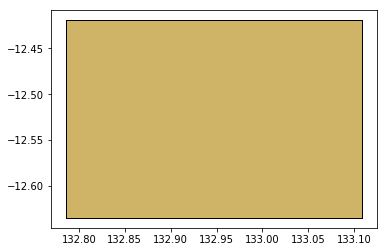

In [14]:
plt.clf()
import geopandas as gpd
shape_plot = gpd.read_file(shape_file)
shape_plot.plot()
plt.show()

In [15]:
#copy attributes from shapefile and define shape_name
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
shape_name = shape_file.split('/')[-1].split('.')[0]+'_'+str(i)

In [16]:
# # #check if the file has already been written:
# filename = netcdf_output_loc+shape_name+'NoPizza.nc'
# if os.path.isfile(filename):
#     print('{} already exists'.format(filename))
#     sys.exit(0)

In [17]:
# # #bring in dask and start it running
# import dask
# dask.set_options(get=dask.get)

In [18]:
#tell the datacube which app to use
dc = datacube.Datacube(app='dc-nbart')

In [19]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Define temporal range
start_of_epoch = '2016-01-01'
#start_of_epoch = '2016-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

In [20]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red',
                     'nir',
                     'swir1',
                     'swir2'
                     ]

In [21]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom,
    'dask_chunks': {'time': 5}
}

For sensor in sensors:
Load data
calculate tcw count
calculate mean tcw count
calculate percentile tcw count (low and high)
calculate
plot mean tcw count



In [22]:
#this is done separately instead of in a loop because the datasets can be quite large.
#currently this is a way of memory handling -there is probably a better way of doing it.
sensor1_nbart=load_nbart('ls5',query,bands_of_interest)
sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
sensor3_nbart=load_nbart('ls8',query,bands_of_interest)

loading ls5_nbart_albers
did not load ls5_nbart_albers
loading ls7_nbart_albers
loaded ls7_nbart_albers
making mask ls7_pq_albers
masked ls7_nbart_albers with ls7_pq_albers and filtered terrain
loading ls8_nbart_albers
loaded ls8_nbart_albers
making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


### Calculate wetness for each timeslice

In [23]:
#run the tcw transform on the surface reflectance data
wetness_sensor1_nbart=calc_wetness(sensor1_nbart,'ls5')
wetness_sensor2_nbart=calc_wetness(sensor2_nbart,'ls7')
wetness_sensor3_nbart=calc_wetness(sensor3_nbart,'ls8')

did not calculate wetness for ls5


/g/data/v10/public/modules/agdc-py3-env/20170713/envs/agdc/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


calculated wetness for ls7
calculated wetness for ls8


### Calculate brightness for each timeslice


In [24]:
#run the tcb transform on the surface reflectance data
brightness_sensor1_nbart=calc_brightness(sensor1_nbart,'ls5')
brightness_sensor2_nbart=calc_brightness(sensor2_nbart,'ls7')
brightness_sensor3_nbart=calc_brightness(sensor3_nbart,'ls8')

did not calculate brightness for ls5


/g/data/v10/public/modules/agdc-py3-env/20170713/envs/agdc/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


calculated brightness for ls7
calculated brightness for ls8


### Calculate greenness for each timeslice


In [25]:
#run the tcg transform on the surface reflectance data
greenness_sensor1_nbart=calc_greenness(sensor1_nbart,'ls5')
greenness_sensor2_nbart=calc_greenness(sensor2_nbart,'ls7')
greenness_sensor3_nbart=calc_greenness(sensor3_nbart,'ls8')

did not calculate greenness for ls5


/g/data/v10/public/modules/agdc-py3-env/20170713/envs/agdc/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


calculated greenness for ls7
calculated greenness for ls8


## this section plots mean wet, bright, green for selected epoch

In [26]:
#make an array of all the wetnessess
tcw_list = []
for wetness in [wetness_sensor1_nbart,wetness_sensor2_nbart, wetness_sensor3_nbart]:
    if wetness is not None:
        tcw_list.append(wetness)
tcw= xr.concat(tcw_list,dim='time')

In [27]:
#make an array of all the brightnessess
tcb_list = []
for brightness in [brightness_sensor1_nbart,brightness_sensor2_nbart, brightness_sensor3_nbart]:
    if brightness is not None:
        tcb_list.append(brightness)
tcb= xr.concat(tcb_list,dim='time')

In [28]:
#make an array of all the brightnessess
tcg_list = []
for greenness in [greenness_sensor1_nbart,greenness_sensor2_nbart, greenness_sensor3_nbart]:
    if greenness is not None:
        tcg_list.append(greenness)
tcg= xr.concat(tcg_list,dim='time')

## take means of each TCI and then plot them as rgb

In [29]:
mean_wet = tcw.mean(dim = 'time')
mean_bright = tcb.mean(dim ='time')
mean_green = tcg.mean(dim ='time')

### max and min values for mean wet, mean bright and mean green

In [30]:
print ('max of mean wet:',mean_wet.wetness.values.max())
print ('max of mean bright:',mean_bright.brightness.values.max())
print ('max of mean green:',mean_green.greenness.values.max())

max of mean wet: 219.072295652
max of mean bright: 10190.5050444
max of mean green: 1868.7785037


In [31]:
print ('min of mean wet:',mean_wet.wetness.values.min())
print ('min of mean bright:',mean_bright.brightness.values.min())
print ('min of mean green:',mean_green.greenness.values.min())

min of mean wet: -2806.10423333
min of mean bright: 428.914117647
min of mean green: -1581.91657222


### output maximum and minimum values for std

In [32]:
# do standard deviation
wet_sd = tcw.std(dim='time', keep_attrs='True',skipna=True)
bright_sd = tcb.std(dim='time', keep_attrs='True',skipna=True)
green_sd = tcg.std(dim='time', keep_attrs='True',skipna=True)

In [33]:
print ('max of wet std:',wet_sd.wetness.values.max())
print ('max of bright std:',bright_sd.brightness.values.max())
print ('max of green std:',green_sd.greenness.values.max())

max of wet std: 1502.26266631
max of bright std: 4252.36678593
max of green std: 1433.35941176


In [34]:
print ('min of wet std:',wet_sd.wetness.values.min())
print ('min of bright std:',bright_sd.brightness.values.min())
print ('min of green std:',green_sd.greenness.values.min())

min of wet std: 36.4039797846
min of bright std: 94.3858630172
min of green std: 33.8517008221


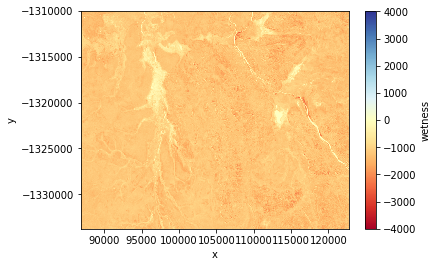

In [35]:
plt.clf()
mean_wet.wetness.plot(vmin=-4000, vmax=4000, cmap ='RdYlBu')
plt.show()

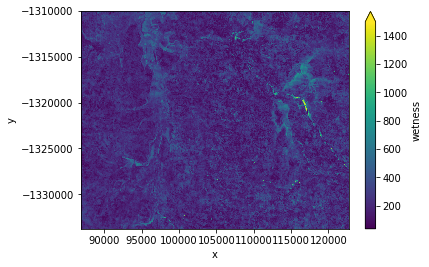

In [36]:
plt.clf()
wet_sd.wetness.plot(vmax =1500)
plt.show()

## plot greenness against wetness

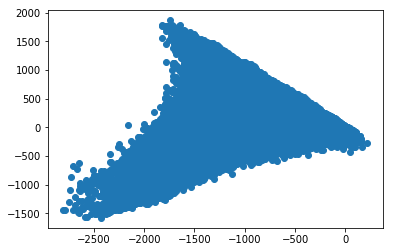

In [37]:
plt.clf()
plt.scatter(mean_wet.wetness.values, mean_green.greenness.values)
plt.show()

In [38]:
import seaborn as sns

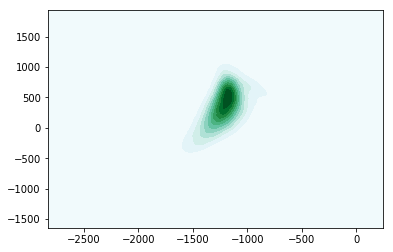

In [39]:
sns.kdeplot(mean_wet.wetness.values.flatten(), mean_green.greenness.values.flatten(), shade=True)
plt.show()

In [ ]:
mean_wet = tcw.mean(dim = 'time')
mean_bright = tcb.mean(dim ='time')
mean_green = tcg.mean(dim ='time')

## normalize each channel (w,b,g)

In [40]:
def normalize(tc):
    '''normalize using feature scaling'''
    
    norm = (tc-tc.min())/(tc.max()-tc.min())
    return norm

In [41]:
B =normalize(mean_wet)*255 
R=normalize(mean_bright)*255 
G=normalize(mean_green)*255 

In [42]:
rgbArray = np.zeros((len(B.wetness.y),len(B.wetness.x),3),'uint8')

In [43]:
rgbArray[...,0] = R.brightness
rgbArray[...,1] = G.greenness
rgbArray[...,2] = B.wetness

In [44]:
img=Image.fromarray(rgbArray)

In [54]:
#shows a big image!
img.show()

In [53]:
img.save('/g/data/r78/rjd547/groundwater_activities/Kakadu/plots/tc_comparison/tc__dcoeffs_rgb_v2.png')